In [ ]:
!pip install eli5
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107720 sha256=ab1c7219063cdb7ccc591ee7702cdf68c2265377148eb0da26012c3bc9ae1023
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


In [ ]:
"import libraries"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# MLP and feature importance
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

In [ ]:
raw_data = pd.read_csv("obesity_food_data.csv")
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2323 entries, 0 to 2322
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CT10                  2323 non-null   int64  
 1   LILATracts_1And10     2323 non-null   float64
 2   LILATracts_halfAnd10  2323 non-null   float64
 3   LILATracts_Vehicle    2323 non-null   float64
 4   HUNVFlag              2323 non-null   float64
 5   LowIncomeTracts       2323 non-null   float64
 6   MedianFamilyIncome    2323 non-null   float64
 7   LA1and10              2323 non-null   float64
 8   LAhalfand10           2323 non-null   float64
 9   LATracts_half         2323 non-null   float64
 10  LATracts1             2323 non-null   float64
 11  TractLOWI             2323 non-null   float64
 12  TractKids             2323 non-null   float64
 13  TractSeniors          2323 non-null   float64
 14  TractWhite            2323 non-null   float64
 15  TractBlack           

In [ ]:
data = raw_data.copy()
columns = ["CT10", "Shape_Length", "Shape_Area"]
data = data.drop(columns, axis=1)
# data.info()

In [ ]:
scaler = MinMaxScaler()
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
# print(numerical_columns)
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])
# print(data.head())

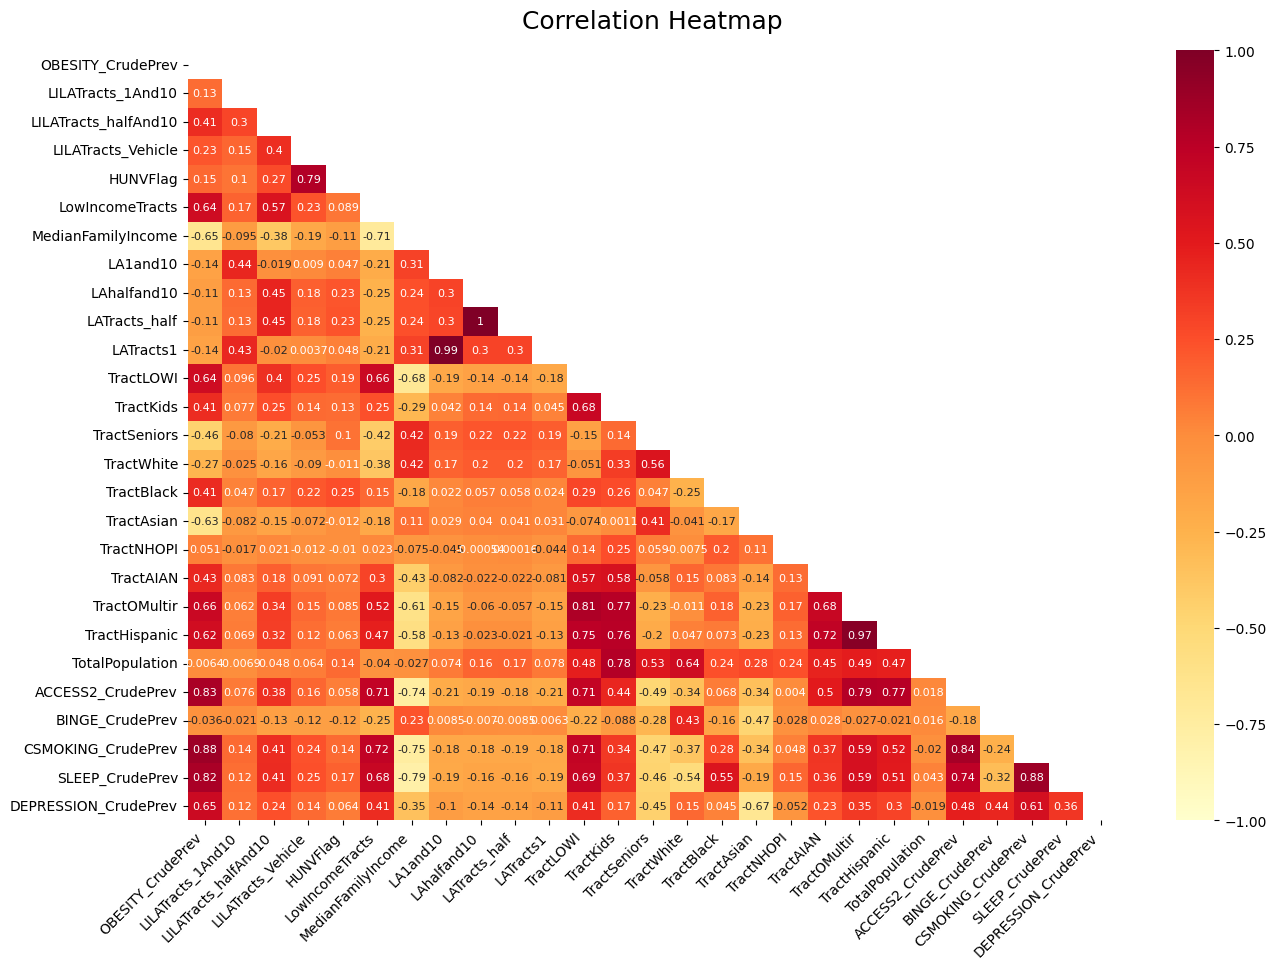

In [ ]:
plt.figure(figsize=(15, 10))

data_sorted = data.sort_values('OBESITY_CrudePrev', ascending=False)

corr_matrix = data_sorted.corr()

ordered_cols = ['OBESITY_CrudePrev'] + [col for col in corr_matrix.columns if col != 'OBESITY_CrudePrev']
corr_matrix = corr_matrix[ordered_cols].reindex(ordered_cols)

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

heatmap = sns.heatmap(corr_matrix, mask=mask, vmin=-1, vmax=1, annot=True, cmap="YlOrRd", annot_kws={"size": 8})
plt.xticks(rotation=45, horizontalalignment="right")
plt.yticks(rotation=0)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16)
plt.show()

In [ ]:
# 假设 data 是已经加载并预处理的DataFrame
factors = ['LILATracts_1And10', 'LILATracts_halfAnd10',
       'LILATracts_Vehicle', 'HUNVFlag', 'LowIncomeTracts',
       'MedianFamilyIncome', 'LA1and10', 'LAhalfand10', 'LATracts_half',
       'LATracts1', 'TractLOWI', 'TractKids', 'TractSeniors', 'TractWhite',
       'TractBlack', 'TractAsian', 'TractNHOPI', 'TractAIAN', 'TractOMultir',
       'TractHispanic', 'TotalPopulation', 'ACCESS2_CrudePrev',
       'BINGE_CrudePrev', 'CSMOKING_CrudePrev', 'SLEEP_CrudePrev',
       'DEPRESSION_CrudePrev']

# 选择特征和目标变量
X = data[factors]
y = data['OBESITY_CrudePrev']

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 训练随机森林回归器
clf = RandomForestRegressor(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 预测并评估模型
y_pred = clf.predict(X_test)
print("Train R2:", clf.score(X_train, y_train) * 100)
print("Test R2:", clf.score(X_test, y_test) * 100)

Train R2: 99.7075702993137
Test R2: 97.55049479482592


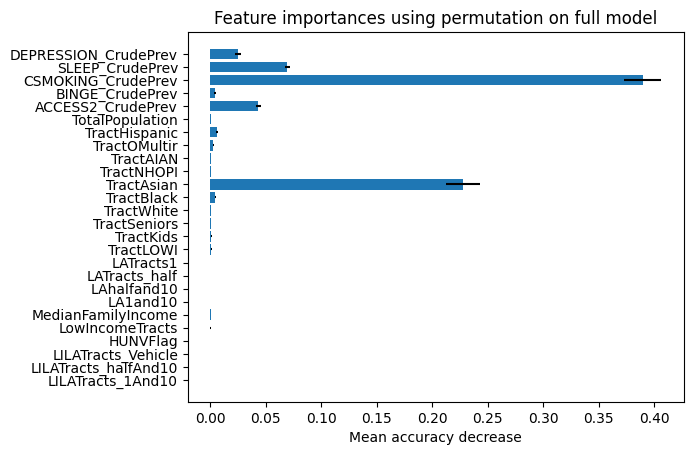

In [ ]:
# 计算特征重要性
result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42)

# 获取重要性数据和标准差
importances_mean = result.importances_mean
importances_std = result.importances_std

# 特征名称
feature_names = X_test.columns.tolist()

# 绘制特征重要性
fig, ax = plt.subplots()
ax.barh(feature_names, importances_mean, xerr=importances_std, align='center')
ax.set_xlabel("Mean accuracy decrease")
ax.set_title("Feature importances using permutation on full model")
plt.show()

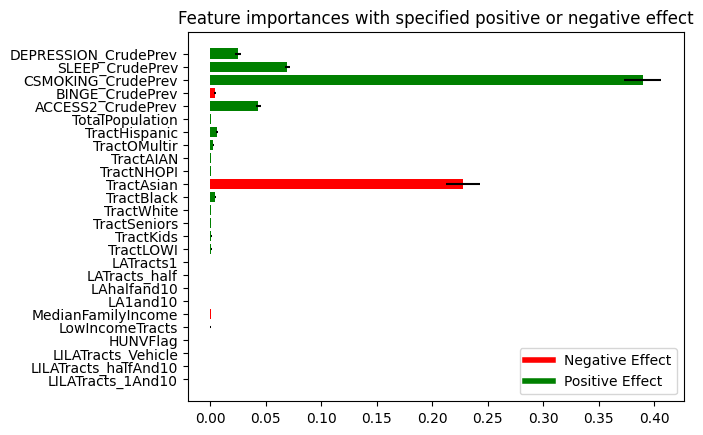

In [ ]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import numpy as np

# 假设 data 是已经加载并预处理的DataFrame
factors = ['LILATracts_1And10', 'LILATracts_halfAnd10',
           'LILATracts_Vehicle', 'HUNVFlag', 'LowIncomeTracts',
           'MedianFamilyIncome', 'LA1and10', 'LAhalfand10', 'LATracts_half',
           'LATracts1', 'TractLOWI', 'TractKids', 'TractSeniors', 'TractWhite',
           'TractBlack', 'TractAsian', 'TractNHOPI', 'TractAIAN', 'TractOMultir',
           'TractHispanic', 'TotalPopulation', 'ACCESS2_CrudePrev',
           'BINGE_CrudePrev', 'CSMOKING_CrudePrev', 'SLEEP_CrudePrev',
           'DEPRESSION_CrudePrev']

# 选择特征和目标变量
X = data[factors]
y = data['OBESITY_CrudePrev']

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 训练随机森林回归器
clf = RandomForestRegressor(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 计算特征重要性
result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42)
importances_mean = result.importances_mean
importances_std = result.importances_std
feature_names = X_test.columns.tolist()

# 指定正负符号序列
sign_sequence = '-+-+---++-+++++-++++++-+++'
colors = ['green' if sign == '+' else 'red' for sign in sign_sequence]

# 绘制特征重要性与指定的正负相关性
fig, ax = plt.subplots()
bars = ax.barh(feature_names, importances_mean, xerr=importances_std, align='center', color=colors)
ax.set_title("Feature importances with specified positive or negative effect")

# 添加颜色图例
red_patch = plt.Line2D([0], [0], color='red', lw=4, label='Negative Effect')
green_patch = plt.Line2D([0], [0], color='green', lw=4, label='Positive Effect')
plt.legend(handles=[red_patch, green_patch])

plt.show()


In [ ]:
# 定义解释变量和响应变量
factors = ['LILATracts_1And10', 'LILATracts_halfAnd10',
       'LILATracts_Vehicle', 'HUNVFlag', 'LowIncomeTracts',
       'MedianFamilyIncome', 'LA1and10', 'LAhalfand10', 'LATracts_half',
       'LATracts1', 'TractLOWI', 'TractKids', 'TractSeniors', 'TractWhite',
       'TractBlack', 'TractAsian', 'TractNHOPI', 'TractAIAN', 'TractOMultir',
       'TractHispanic', 'TotalPopulation', 'ACCESS2_CrudePrev',
       'BINGE_CrudePrev', 'CSMOKING_CrudePrev', 'SLEEP_CrudePrev',
       'DEPRESSION_CrudePrev']

X = data[factors]
y = data["OBESITY_CrudePrev"]

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# 训练XGBoost模型
xgb_model = XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3,
                         learning_rate = 0.1, max_depth = 5, alpha = 10,
                         n_estimators = 100, random_state=42)

xgb_model.fit(X_train, y_train)

# 预测并计算R2分数
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)
print(f"Train R2: {xgb_model.score(X_train, y_train) * 100:.2f}%")
print(f"Test R2: {xgb_model.score(X_test, y_test) * 100:.2f}%")

# # 特征重要性评估
# perm = permutation_importance(xgb_model, X_test, y_test, n_repeats=10, random_state=42)
# eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Train R2: 92.01%
Test R2: 91.62%


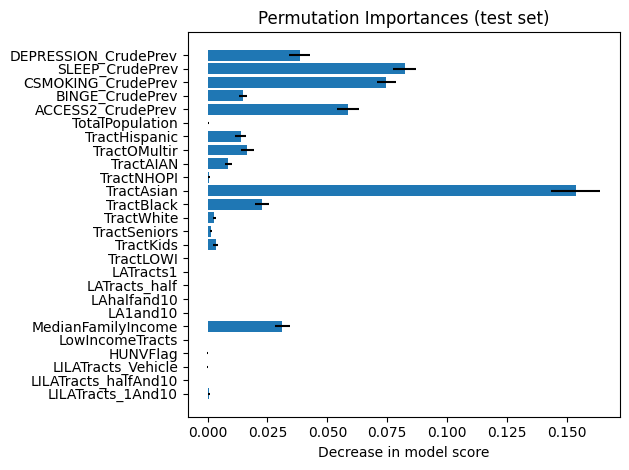

In [ ]:
# 获取特征重要性的值和对应的标准差
importances = perm.importances_mean
std = perm.importances_std

# 获取特征名称
features = X_test.columns

# 创建一个条形图
fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances, xerr=std, align='center')
ax.set_yticks(range(len(importances)))
ax.set_yticklabels(features)
ax.set_title('Permutation Importances (test set)')
ax.set_xlabel('Decrease in model score')
fig.tight_layout()
plt.show()

Train R2: 92.01%
Test R2: 91.62%


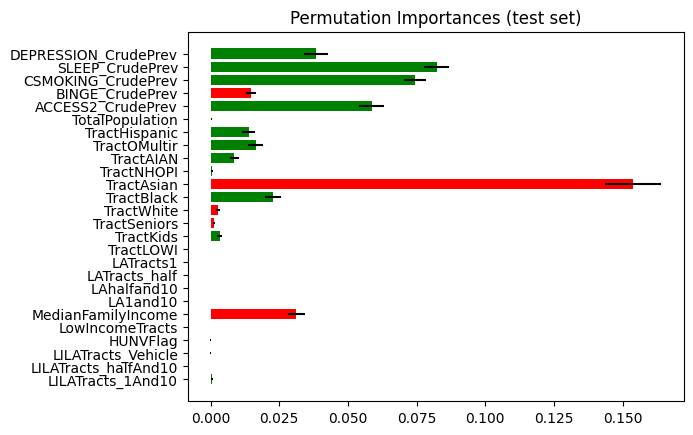

In [ ]:
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 假设 data 已加载和预处理
factors = ['LILATracts_1And10', 'LILATracts_halfAnd10',
           'LILATracts_Vehicle', 'HUNVFlag', 'LowIncomeTracts',
           'MedianFamilyIncome', 'LA1and10', 'LAhalfand10', 'LATracts_half',
           'LATracts1', 'TractLOWI', 'TractKids', 'TractSeniors', 'TractWhite',
           'TractBlack', 'TractAsian', 'TractNHOPI', 'TractAIAN', 'TractOMultir',
           'TractHispanic', 'TotalPopulation', 'ACCESS2_CrudePrev',
           'BINGE_CrudePrev', 'CSMOKING_CrudePrev', 'SLEEP_CrudePrev',
           'DEPRESSION_CrudePrev']

X = data[factors]
y = data["OBESITY_CrudePrev"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

xgb_model = XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3,
                         learning_rate = 0.1, max_depth = 5, alpha = 10,
                         n_estimators = 100, random_state=42)
xgb_model.fit(X_train, y_train)

# 预测并计算R2分数
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)
print(f"Train R2: {xgb_model.score(X_train, y_train) * 100:.2f}%")
print(f"Test R2: {xgb_model.score(X_test, y_test) * 100:.2f}%")

# 特征重要性评估
perm = permutation_importance(xgb_model, X_test, y_test, n_repeats=10, random_state=42)

# 显示重要性图表
features = X_test.columns
importances = perm.importances_mean
std = perm.importances_std

# 指定正负符号序列
sign_sequence = '+++++-++++++--+-++++++-+++'
colors = ['green' if sign == '+' else 'red' for sign in sign_sequence]

fig, ax = plt.subplots()
ax.barh(features, importances, xerr=std, color=colors)
ax.set_title('Permutation Importances (test set)')
plt.show()


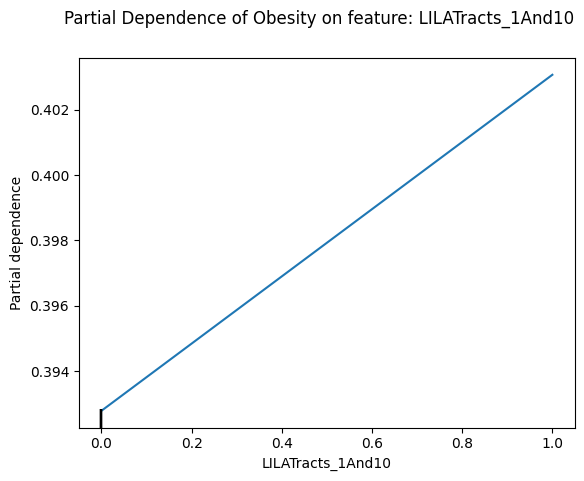

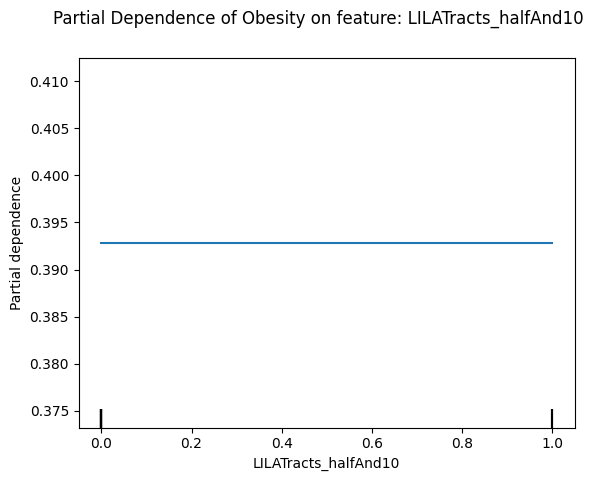

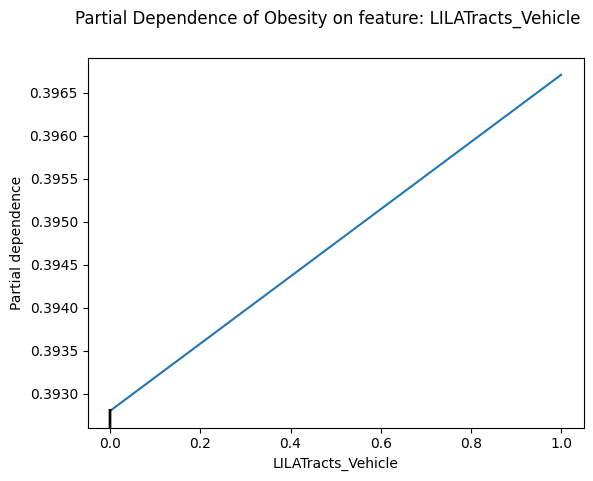

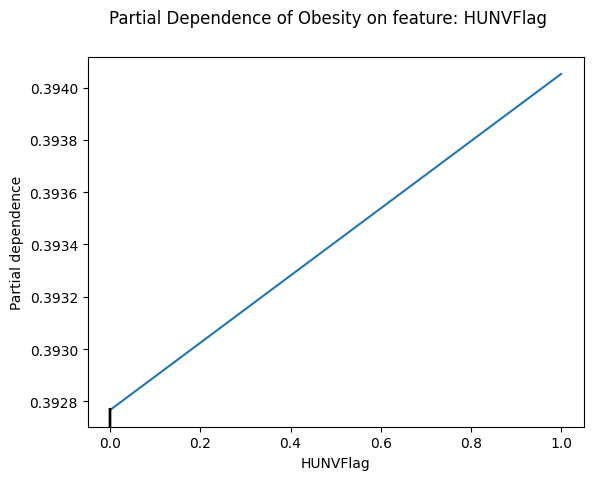

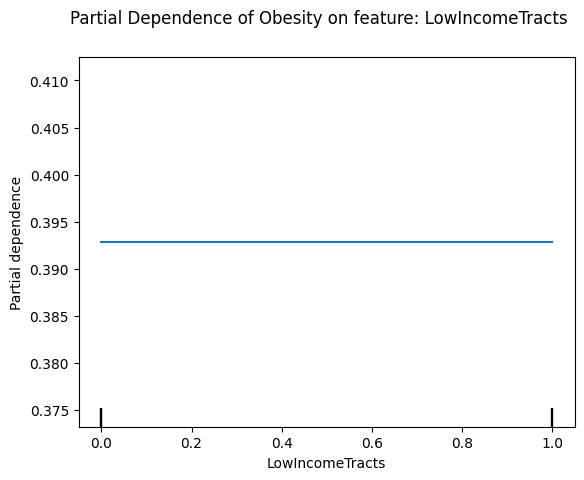

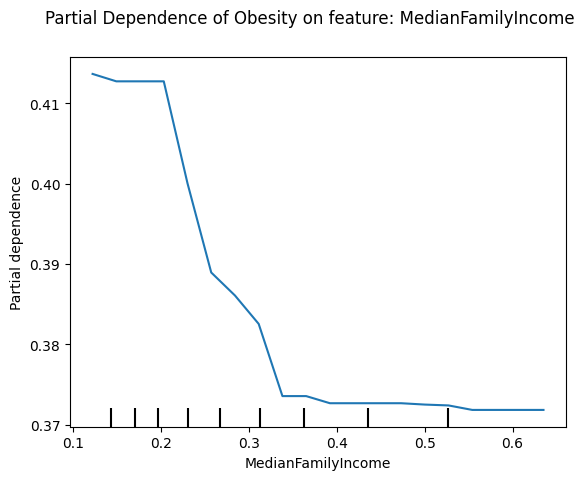

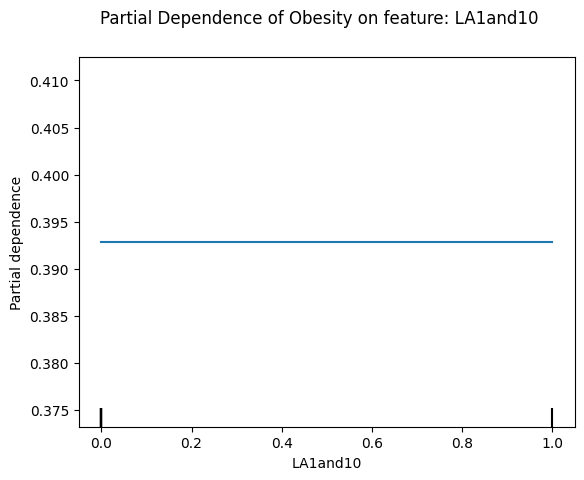

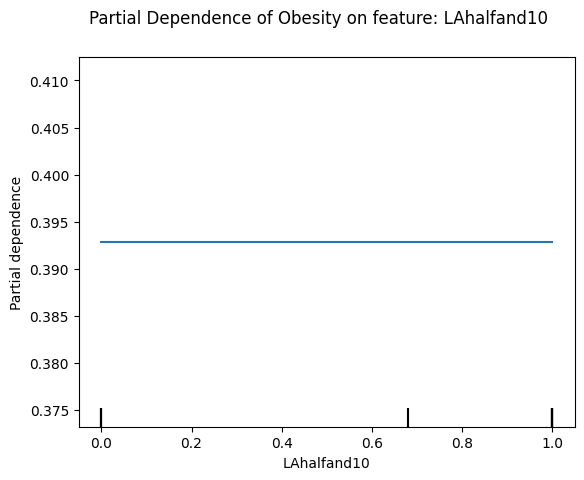

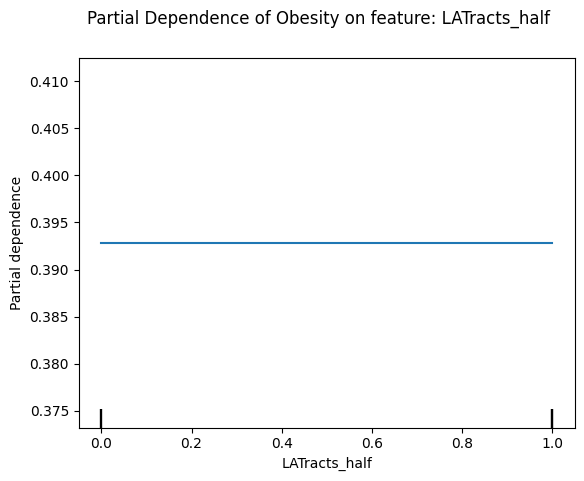

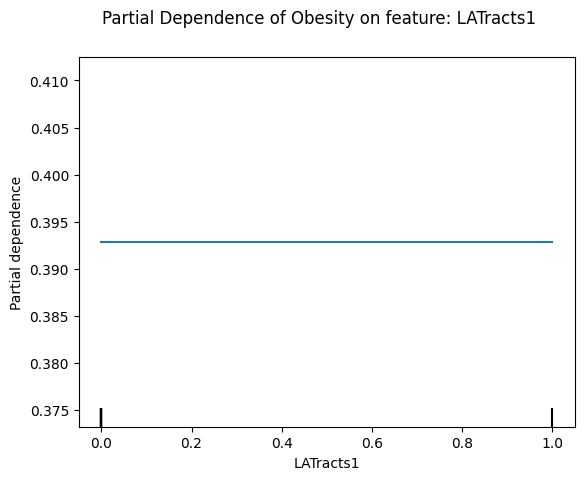

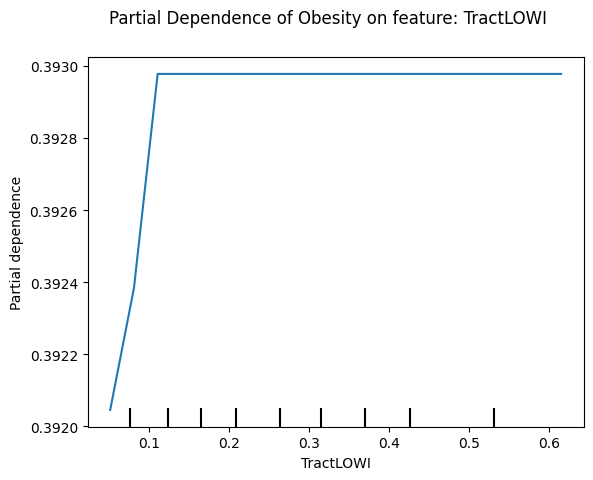

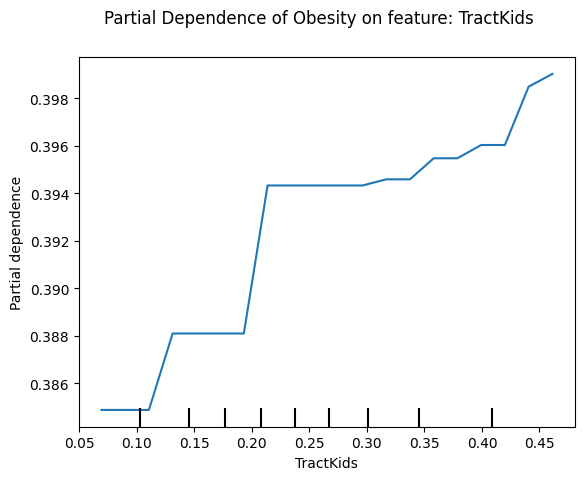

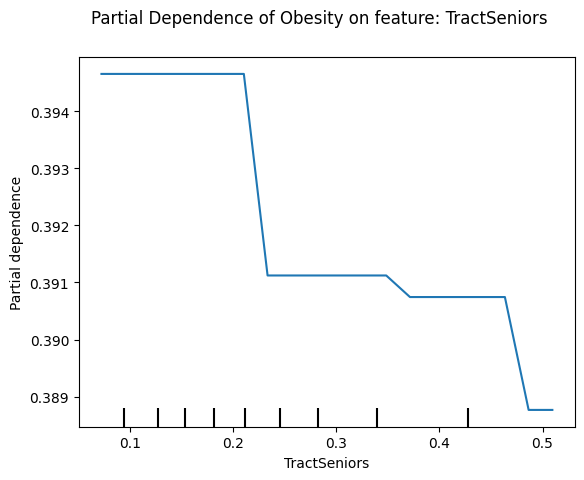

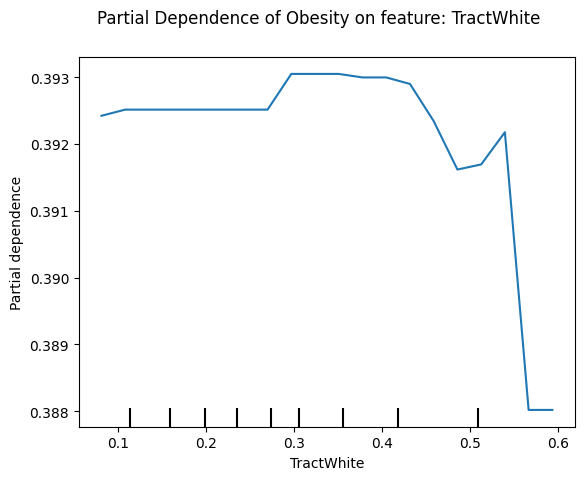

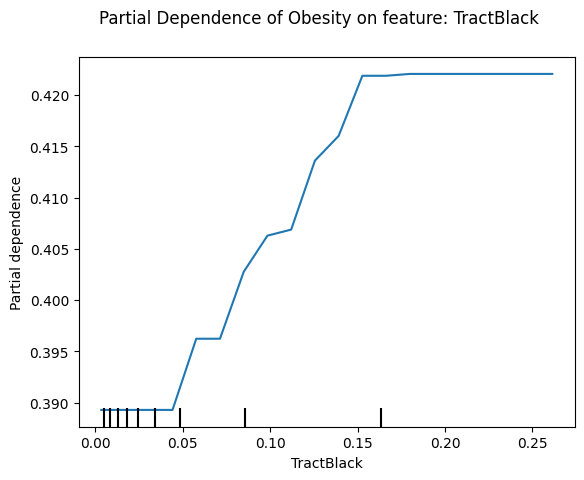

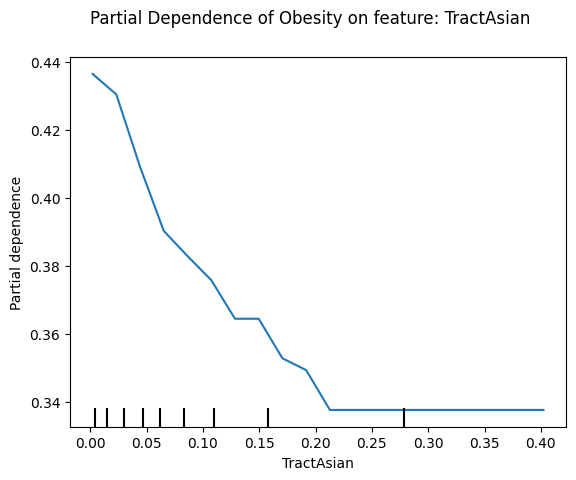

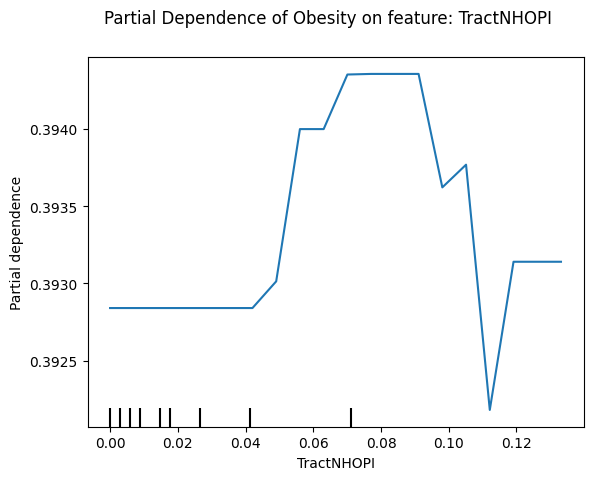

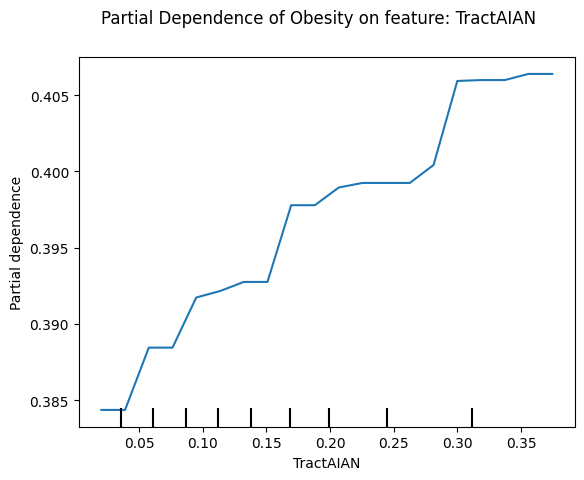

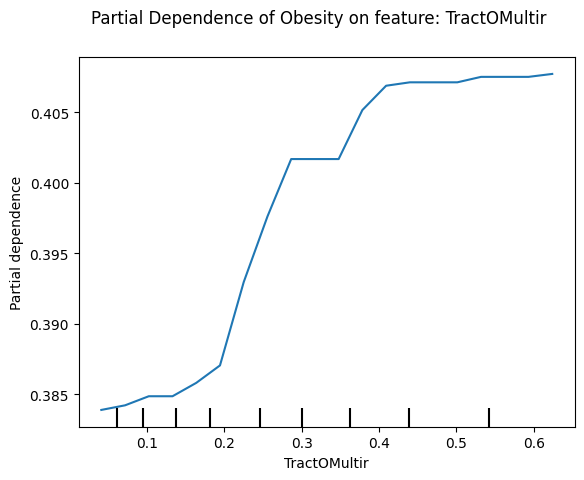

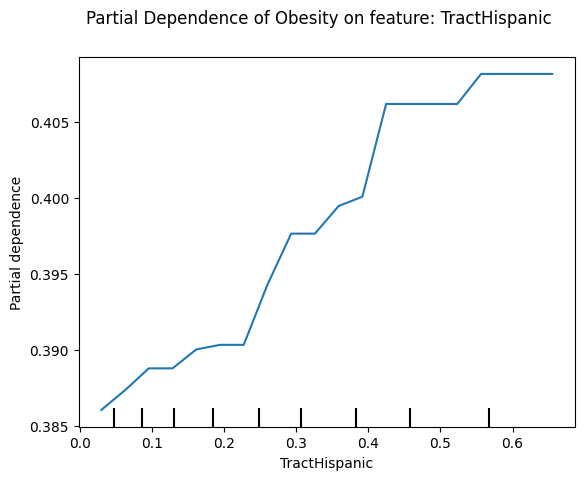

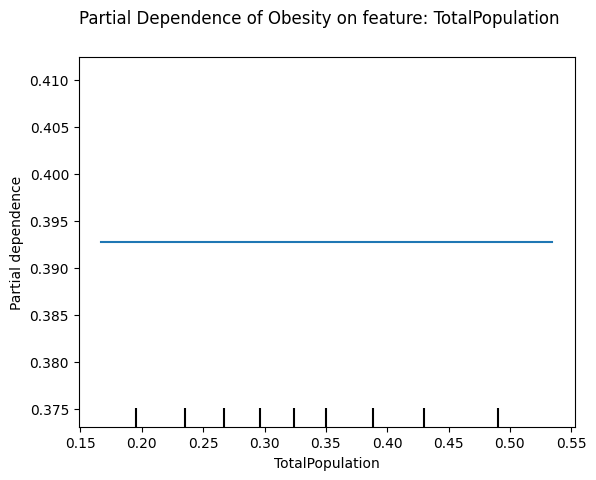

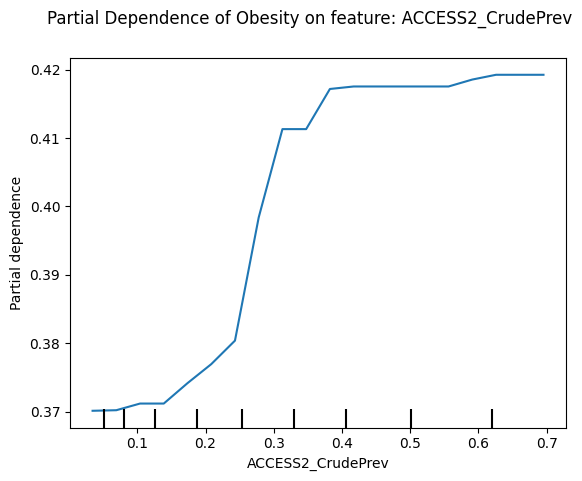

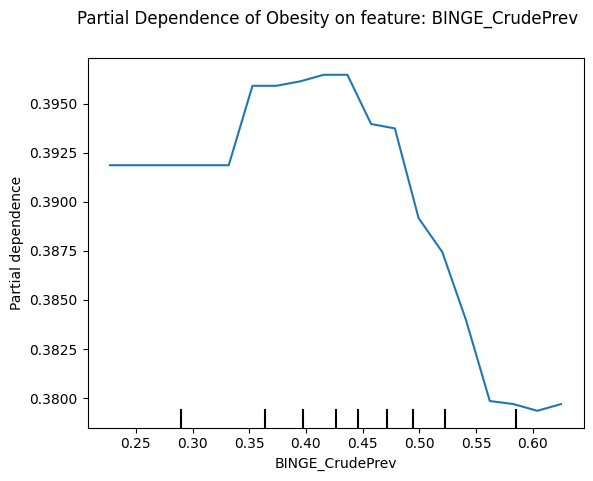

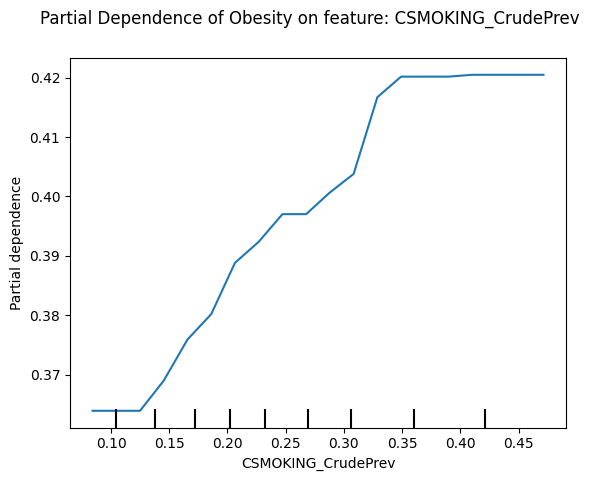

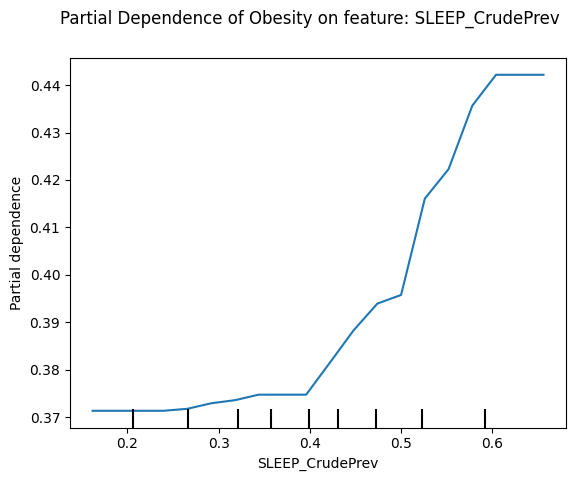

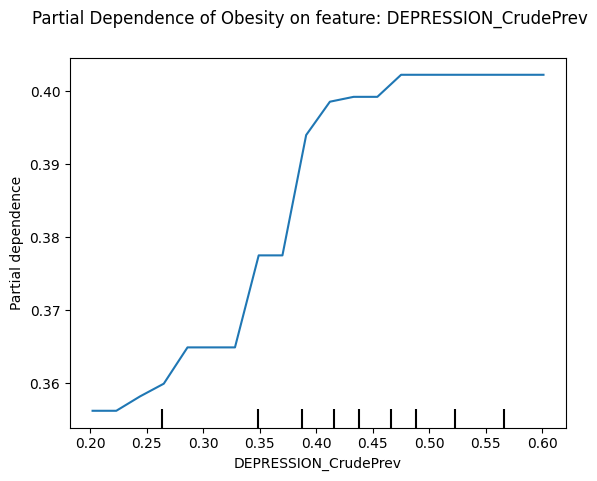

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.inspection import PartialDependenceDisplay

# 假设数据已经被加载到 DataFrame `data` 中
factors = ['LILATracts_1And10', 'LILATracts_halfAnd10',
           'LILATracts_Vehicle', 'HUNVFlag', 'LowIncomeTracts',
           'MedianFamilyIncome', 'LA1and10', 'LAhalfand10', 'LATracts_half',
           'LATracts1', 'TractLOWI', 'TractKids', 'TractSeniors', 'TractWhite',
           'TractBlack', 'TractAsian', 'TractNHOPI', 'TractAIAN', 'TractOMultir',
           'TractHispanic', 'TotalPopulation', 'ACCESS2_CrudePrev',
           'BINGE_CrudePrev', 'CSMOKING_CrudePrev', 'SLEEP_CrudePrev',
           'DEPRESSION_CrudePrev']

X = data[factors]
y = data["OBESITY_CrudePrev"]

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建XGBoost模型
xgb_model = XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3,
                         learning_rate=0.1, max_depth=5, alpha=10,
                         n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# 绘制部分依赖图 (PDP) 对于每个特征
for feature in factors:
    display = PartialDependenceDisplay.from_estimator(
        xgb_model,
        X_train,
        features=[feature],
        kind="average",
        grid_resolution=20 # 选择一个适当的网格分辨率
    )
    display.figure_.suptitle('Partial Dependence of Obesity on feature: ' + feature)
    display.figure_.subplots_adjust(hspace=0.3)  # 调整子图间距
    plt.show()


In [ ]:
pip install pdpbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.8/35.8 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 11.8 MB/s eta 0:00:00
  Attempting uninstall: sphinx
    Found existing installation: Sphinx 5.0.2
    Uninstalling Sphinx-5.0.2:
      Successfully uninstalled Sphinx-5.0.2


In [ ]:
# Manually extracted and cleaned up the OCR results for accuracy
# Original text from OCR contains misinterpretations; hence, manual extraction is performed
variables = [
    "Intercept", "LILATRACTS", "HUNVFLAG", "LOWINCOMET", "MEDIANFAMI",
    "LA1AND10", "LATRACTS1", "TRACTLOWI", "TRACTKIDS", "TRACTSENIO",
    "TRACTASIAN", "TOTALPOPUL", "ACCESS2_CR", "BINGE_CRUD", "CSMOKING_C",
    "SLEEP_CRUD", "DEPRESSION"
]

coefficients = [
    -0.016225, -0.078236, 0.274557, 0.040192, 0.000001,
    0.311699, -0.279046, -0.000272, 0.001109, 0.001735,
    -0.003548, 0.000068, 0.151268, -0.054565, 0.256665,
    0.721787, 0.045980
]

# Create a dictionary from variables and coefficients
model_coefficients = dict(zip(variables, coefficients))

# Display the model coefficients
model_coefficients


{'Intercept': -0.016225,
 'LILATRACTS': -0.078236,
 'HUNVFLAG': 0.274557,
 'LOWINCOMET': 0.040192,
 'MEDIANFAMI': 1e-06,
 'LA1AND10': 0.311699,
 'LATRACTS1': -0.279046,
 'TRACTLOWI': -0.000272,
 'TRACTKIDS': 0.001109,
 'TRACTSENIO': 0.001735,
 'TRACTASIAN': -0.003548,
 'TOTALPOPUL': 6.8e-05,
 'ACCESS2_CR': 0.151268,
 'BINGE_CRUD': -0.054565,
 'CSMOKING_C': 0.256665,
 'SLEEP_CRUD': 0.721787,
 'DEPRESSION': 0.04598}

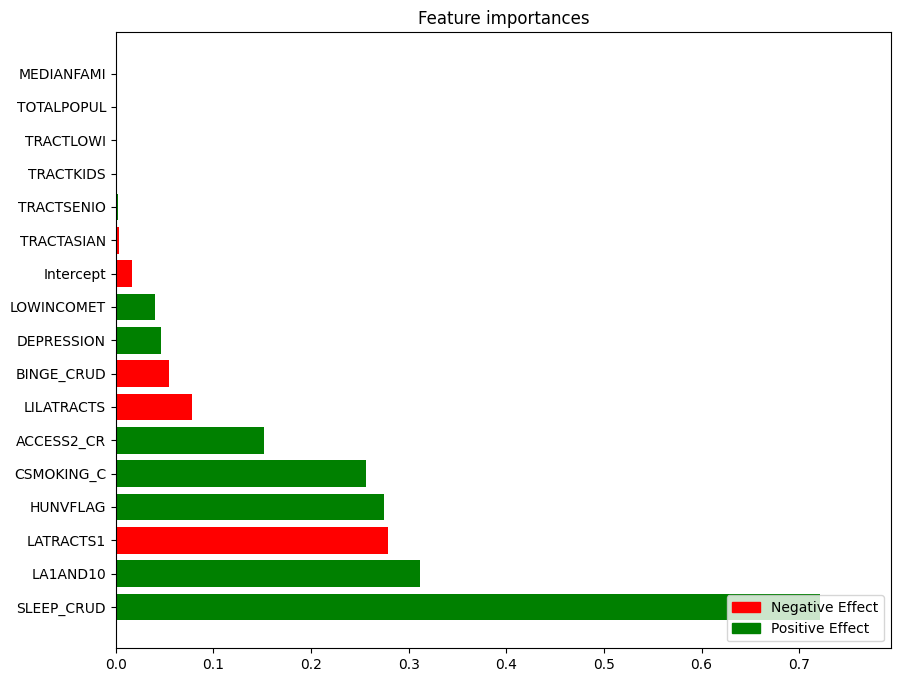

In [ ]:
import matplotlib.pyplot as plt

# Given data from the text extraction
variables = [
    "Intercept", "LILATRACTS", "HUNVFLAG", "LOWINCOMET", "MEDIANFAMI",
    "LA1AND10", "LATRACTS1", "TRACTLOWI", "TRACTKIDS", "TRACTSENIO",
    "TRACTASIAN", "TOTALPOPUL", "ACCESS2_CR", "BINGE_CRUD", "CSMOKING_C",
    "SLEEP_CRUD", "DEPRESSION"
]
coefficients = [
    -0.016225, -0.078236, 0.274557, 0.040192, 0.000001,
    0.311699, -0.279046, -0.000272, 0.001109, 0.001735,
    -0.003548, 0.000068, 0.151268, -0.054565, 0.256665,
    0.721787, 0.045980
]

# Assuming positive effect for positive coefficient and negative for negative coefficient
colors = ['green' if coef > 0 else 'red' for coef in coefficients]

# Sorting the variables and coefficients by the absolute value of coefficients
sorted_vars = [var for _, var in sorted(zip(map(abs, coefficients), variables), reverse=True)]
sorted_coefs = sorted(map(abs, coefficients), reverse=True)
sorted_colors = [color for _, color in sorted(zip(map(abs, coefficients), colors), reverse=True)]

# Plotting the feature importances
plt.figure(figsize=(10, 8))
plt.barh(sorted_vars, sorted_coefs, color=sorted_colors)
plt.title('Feature importances')
plt.xlim(0, max(sorted_coefs)*1.1)  # Extend x-axis limit for better visual

# Creating custom legend
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Negative Effect')
green_patch = mpatches.Patch(color='green', label='Positive Effect')
plt.legend(handles=[red_patch, green_patch], loc='lower right')

plt.show()
